## Riehl 1963


In [1]:
# General
import glob
import os.path
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from matplotlib.colors import Normalize
# from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import pandas as pd

# Data treatment
import dask as da
from dask.diagnostics import ProgressBar
import zarr
from scipy.interpolate import griddata
from scipy.signal import convolve2d
from scipy.signal import argrelextrema
from datetime import datetime

# Custom
import functions as f

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
PARAMS = {'save_figs':       False,
#           'data_dir':        '/home/arthur/data/cyclobs/centered_rotated_files_31012022/',
          'ds_glob_path':    '/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_13052022_with_extra_params.nc',
#           'ds_glob_path_Rw': '/home/arthur/data/cyclobs/SAR_compilations_in_nc/ds_glob_Rw',
#           'save_dir':        '/home/arthur/results/ck22model/ck22model_scatter/lat30_cat1_allbasins/',
          
#           'filter_data':     True, # If True, filters out storms and TC > 30°N
}

### OPEN DATA
dsg = xr.open_dataset(PARAMS['ds_glob_path'])
# ds_glob = xr.open_dataset(PARAMS['ds_glob_path_Rw'])
print('Nb of storms: {}'.format(len(dsg.time)))

Nb of storms: 335


In [3]:
### FUNCTIONS
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                            # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter at 20° latitude and assuming it's constant 
    return fcor

#### Equation 13

Rmax = R0 ^ 3 * f ^ 2 / (4 * V0 ^ 2)

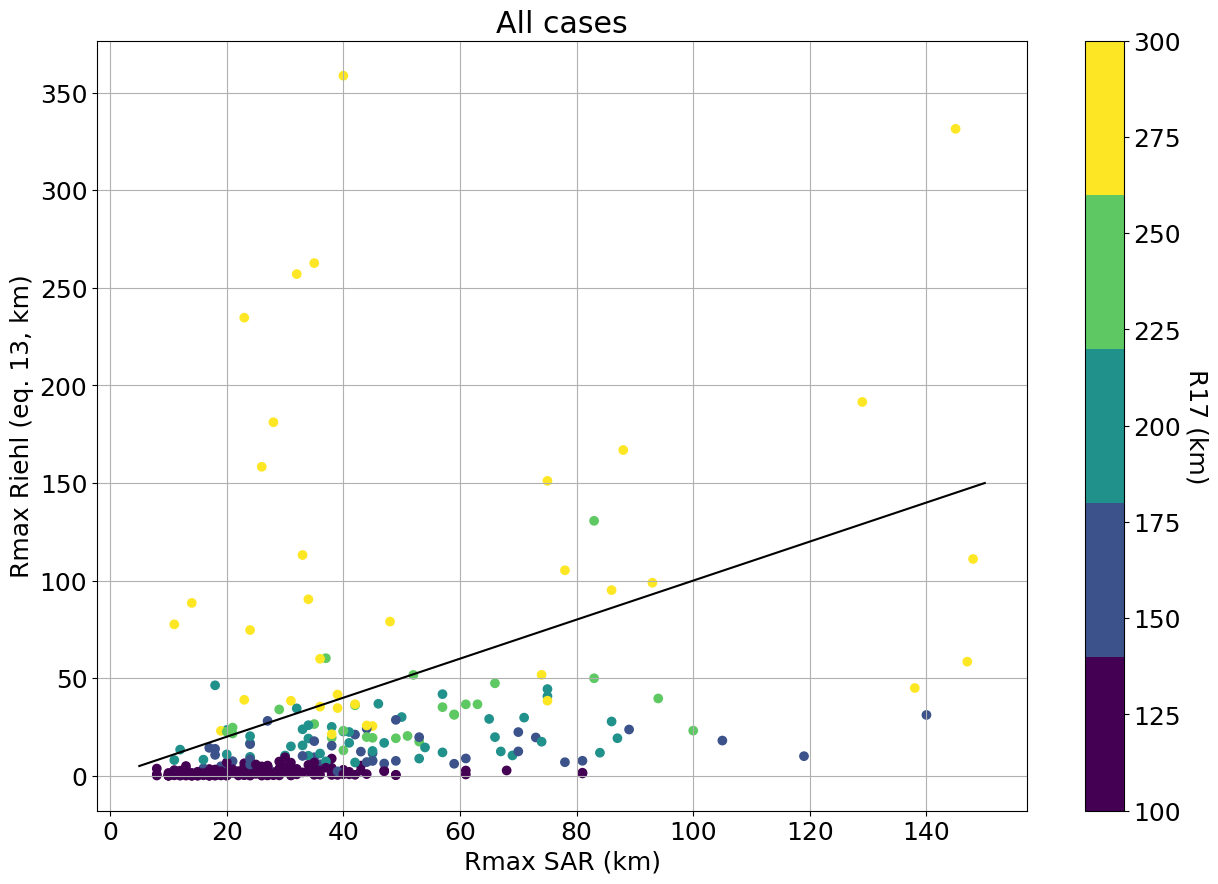

In [4]:
dsg['ri'] = ((dsg['R17_1D'] * 1000) ** 3) * (coriolis(abs(dsg['lat_center'])) ** 2) / (4 * 17.5 ** 2)

plt.title('All cases')
plt.scatter(dsg['Rmax_1D'], dsg['ri'] / 1000, c=dsg['R17_1D'], vmin=100, vmax=300, cmap=cm.get_cmap('viridis', 5))
plt.xlabel('Rmax SAR (km)');plt.ylabel('Rmax Riehl (eq. 13, km)')
plt.grid()

plt.plot([5, 150], [5, 150], c='k')

cbar    = plt.colorbar()
cbar.set_label('R17 (km)', rotation=270)
cbar.ax.get_yaxis().labelpad=20

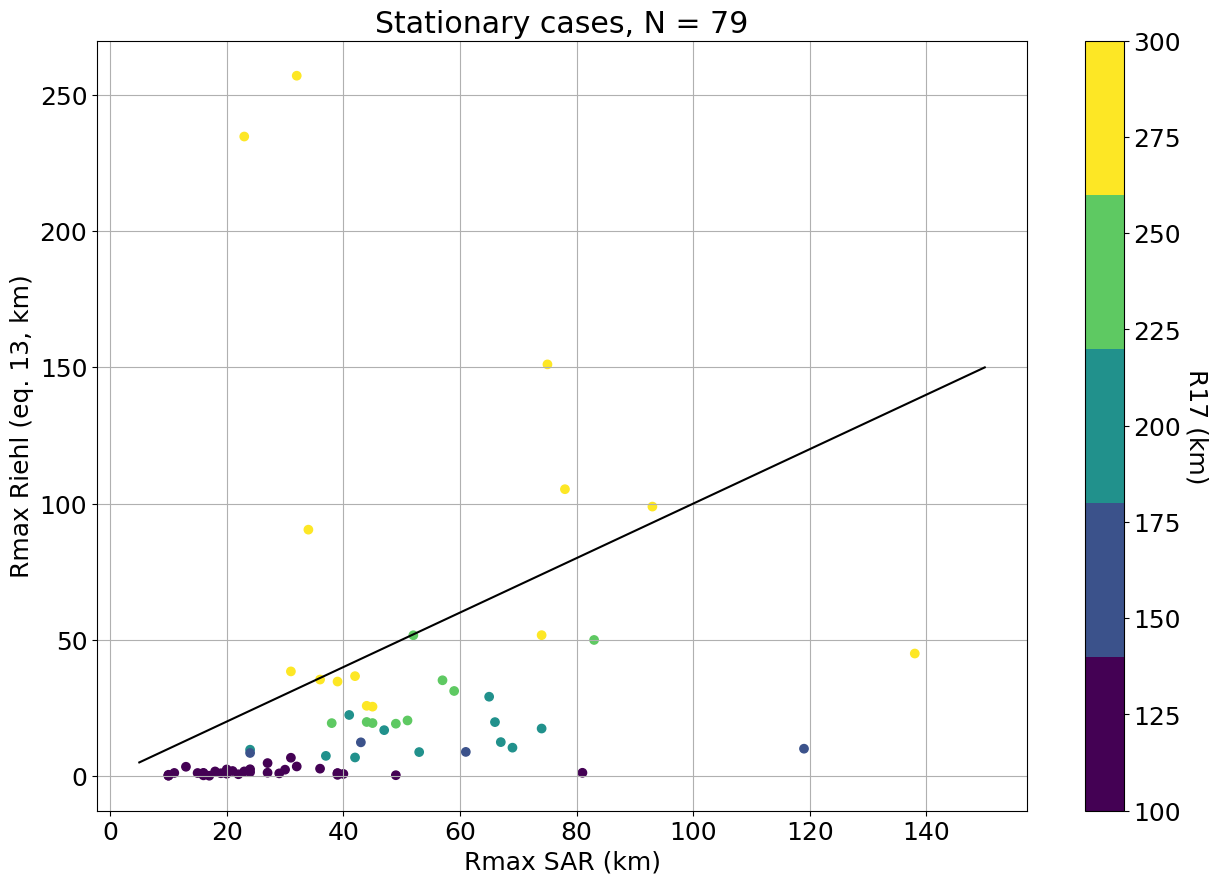

In [5]:
dsg2 = xr.open_dataset('/home/arthur/results/TCsLifeMonitFromObs/07_SAR_K10/ds_glob.nc')
dsg['Vmax_dot_smth_IBT'] = dsg2['Vmax_dot_smth_IBT']

d = dsg.where(abs(dsg.Vmax_dot_smth_IBT) < 0.3, drop=True)
d = d.where(abs(d.lat_center) < 30, drop=True)
d = d.where(d.distance_to_coast > 200000, drop=True)

plt.title('Stationary cases, N = {}'.format(len(d.time)))
plt.scatter(d['Rmax_1D'], d['ri'] / 1000, c=d['R17_1D'], vmin=100, vmax=300, cmap=cm.get_cmap('viridis', 5))
plt.xlabel('Rmax SAR (km)');plt.ylabel('Rmax Riehl (eq. 13, km)')
plt.grid()

plt.plot([5, 150], [5, 150], c='k')

cbar    = plt.colorbar()
cbar.set_label('R17 (km)', rotation=270)
cbar.ax.get_yaxis().labelpad=20

In [6]:
# plt.title('All cases')
# plt.scatter(dsg['Rmax_1D'], dsg['ri'] / 1000, c=dsg['Vmax_1D'], cmap=cm.get_cmap('viridis', 5), vmin=30, vmax=50);plt.colorbar()
# plt.xlabel('Rmax SAR (km)');plt.ylabel('Rmax Riehl (eq. 13, km)')
# plt.grid()

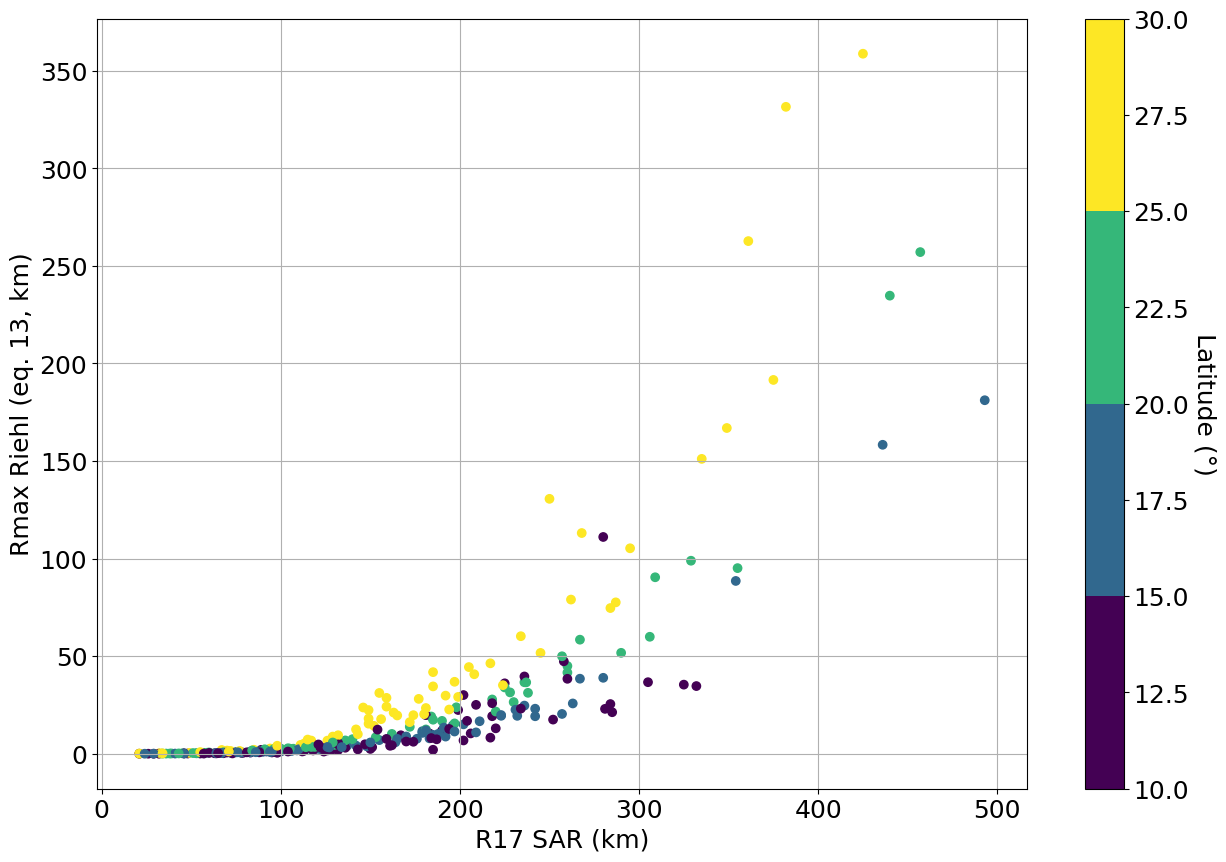

In [7]:
plt.scatter(dsg['R17_1D'], dsg['ri'] / 1000, c=dsg['lat_center'], cmap=cm.get_cmap('viridis', 4), vmin=10, vmax=30)
# plt.scatter(dsg['R17_1D'], dsg['Rmax_1D'], c=dsg['lat_center'], cmap=cm.get_cmap('viridis', 4), vmin=10, vmax=30)
plt.xlabel('R17 SAR (km)');plt.ylabel('Rmax Riehl (eq. 13, km)')
plt.grid()

cbar    = plt.colorbar()
cbar.set_label('Latitude (°)', rotation=270)
cbar.ax.get_yaxis().labelpad=20

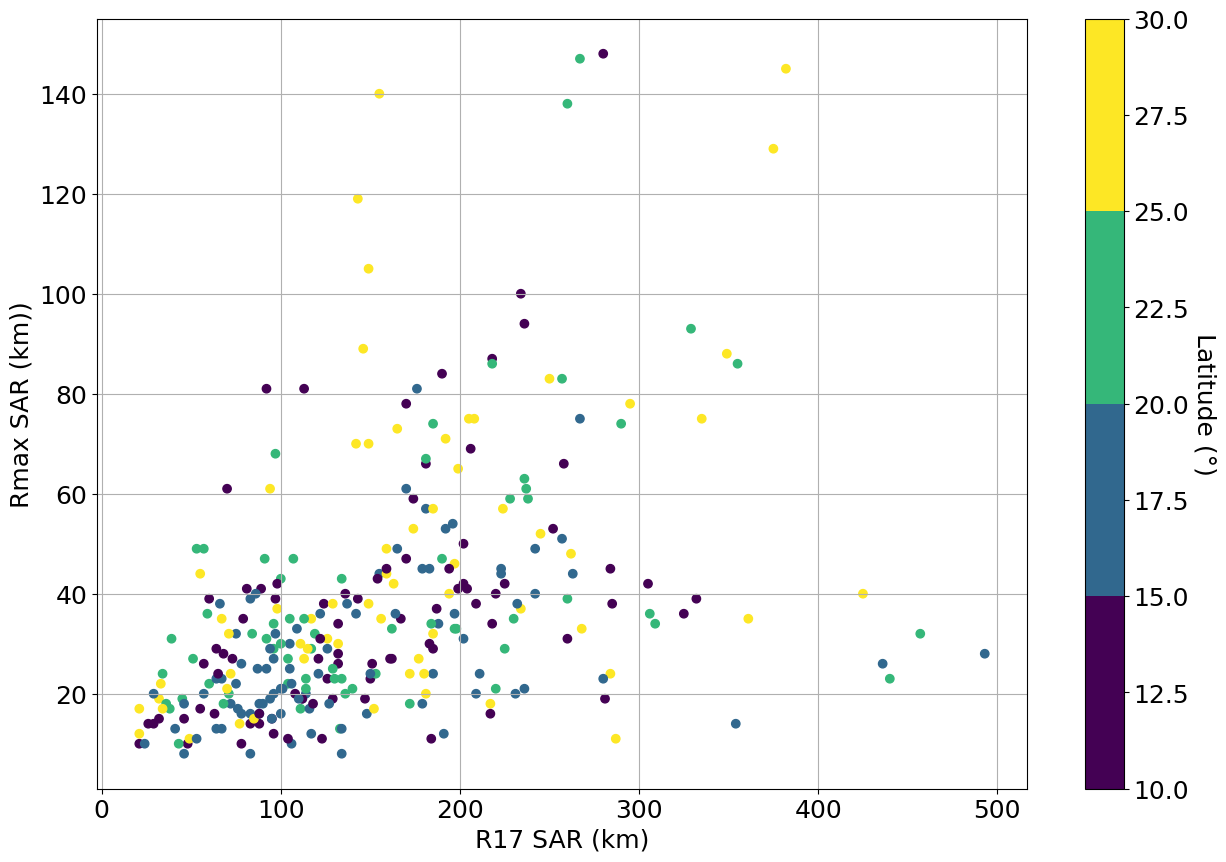

In [8]:
plt.scatter(dsg['R17_1D'], dsg['Rmax_1D'], c=dsg['lat_center'], cmap=cm.get_cmap('viridis', 4), vmin=10, vmax=30)
plt.xlabel('R17 SAR (km)');plt.ylabel('Rmax SAR (km))')
plt.grid()

cbar    = plt.colorbar()
cbar.set_label('Latitude (°)', rotation=270)
cbar.ax.get_yaxis().labelpad=20

#### Equation 14

Vmax = 2 * V17 ** 2 / (f * R17)

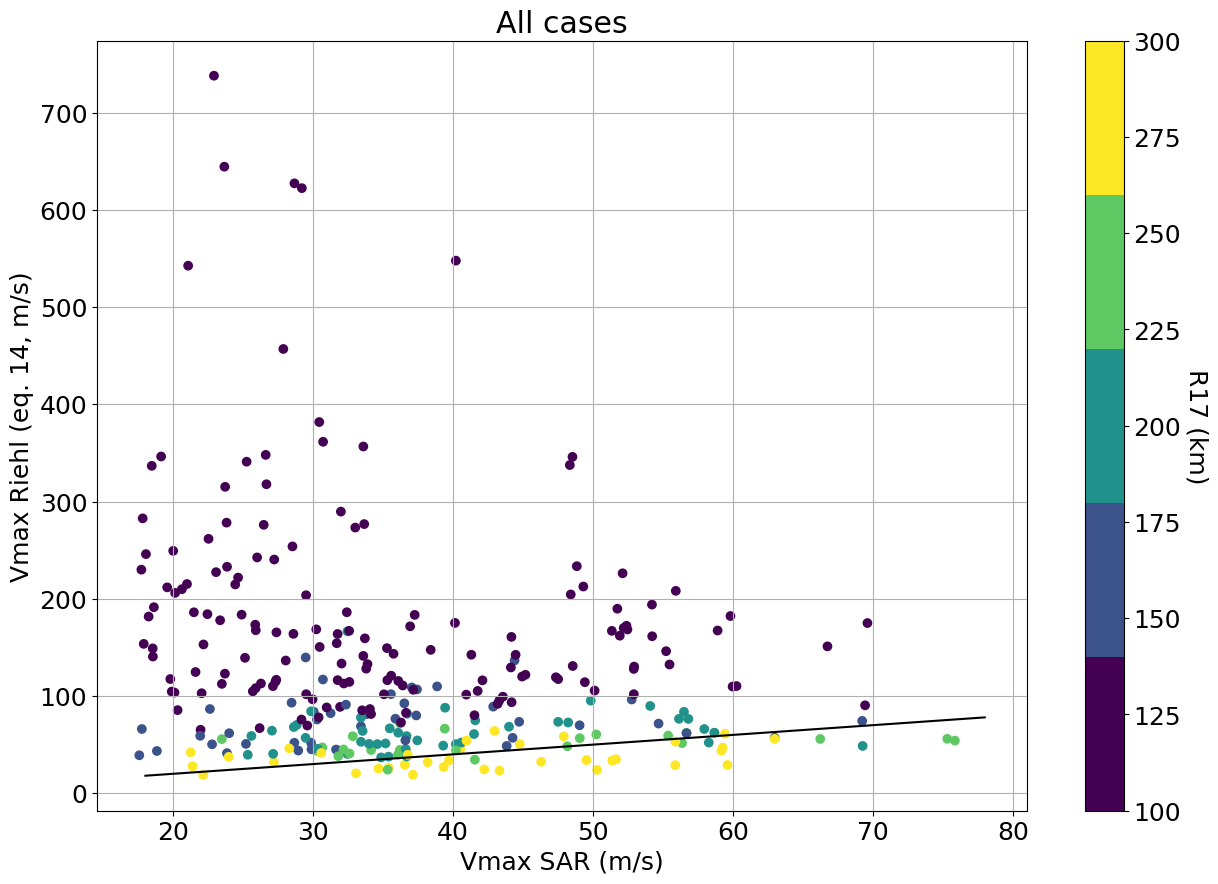

In [9]:
dsg['vi'] = 2 * 17.5 ** 2 / (coriolis(abs(dsg['lat_center'])) * dsg['R17_1D'] * 1000)

plt.title('All cases')
plt.scatter(dsg['Vmax_1D'], dsg['vi'], c=dsg['R17_1D'], vmin=100, vmax=300, cmap=cm.get_cmap('viridis', 5))
plt.xlabel('Vmax SAR (m/s)');plt.ylabel('Vmax Riehl (eq. 14, m/s)')
plt.grid()

plt.plot([18, 78], [18, 78], c='k')

cbar    = plt.colorbar()
cbar.set_label('R17 (km)', rotation=270)
cbar.ax.get_yaxis().labelpad=20

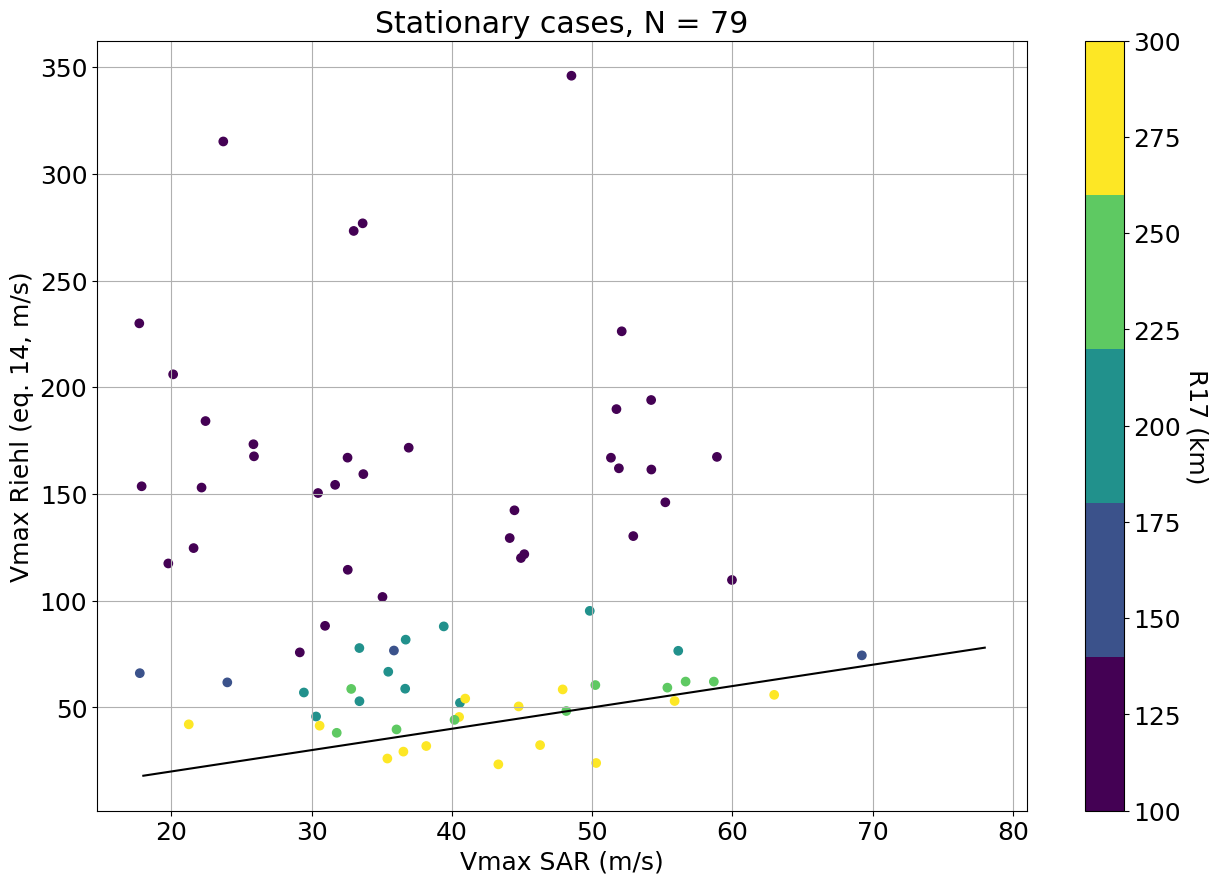

In [10]:
d = dsg.where(abs(dsg.Vmax_dot_smth_IBT) < 0.3, drop=True)
d = d.where(abs(d.lat_center) < 30, drop=True)
d = d.where(d.distance_to_coast > 200000, drop=True)

plt.title('Stationary cases, N = {}'.format(len(d.time)))
plt.scatter(d['Vmax_1D'], d['vi'], c=d['R17_1D'], vmin=100, vmax=300, cmap=cm.get_cmap('viridis', 5))
plt.xlabel('Vmax SAR (m/s)');plt.ylabel('Vmax Riehl (eq. 14, m/s)')
plt.grid()

plt.plot([18, 78], [18, 78], c='k')

cbar    = plt.colorbar()
cbar.set_label('R17 (km)', rotation=270)
cbar.ax.get_yaxis().labelpad=20

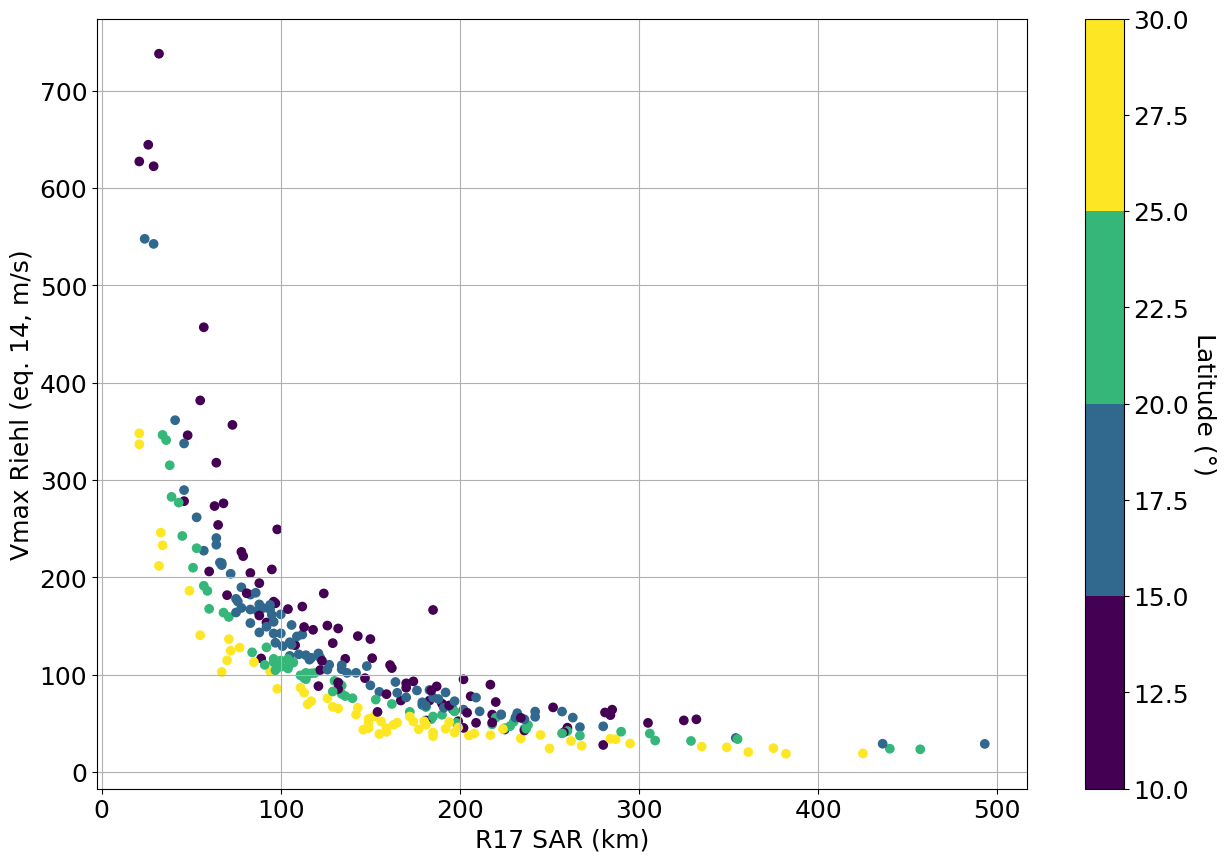

In [11]:
plt.scatter(dsg['R17_1D'], dsg['vi'], c=dsg['lat_center'], cmap=cm.get_cmap('viridis', 4), vmin=10, vmax=30)
plt.xlabel('R17 SAR (km)');plt.ylabel('Vmax Riehl (eq. 14, m/s)')
plt.grid()

cbar    = plt.colorbar()
cbar.set_label('Latitude (°)', rotation=270)
cbar.ax.get_yaxis().labelpad=20

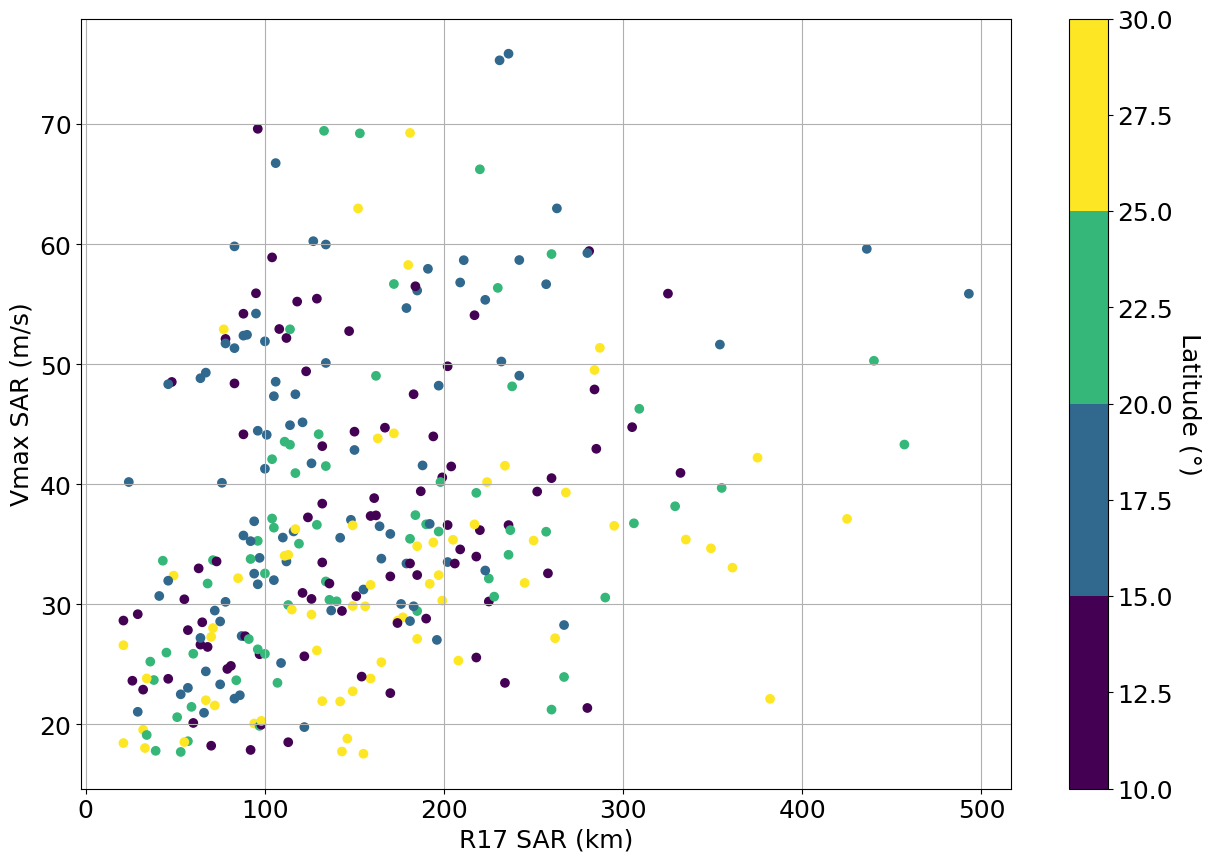

In [12]:
plt.scatter(dsg['R17_1D'], dsg['Vmax_1D'], c=dsg['lat_center'], cmap=cm.get_cmap('viridis', 4), vmin=10, vmax=30)
plt.xlabel('R17 SAR (km)');plt.ylabel('Vmax SAR (m/s)')
plt.grid()

cbar    = plt.colorbar()
cbar.set_label('Latitude (°)', rotation=270)
cbar.ax.get_yaxis().labelpad=20

In [13]:
# d = dsg.where(abs(dsg.B_hol - 2) < 0.1, drop=True)

# plt.title('All cases')
# plt.scatter(d['Vmax_1D'], d['vi'], c=d['R17_1D'], vmin=100, vmax=300, cmap=cm.get_cmap('viridis', 5))
# plt.xlabel('Vmax SAR (m/s)');plt.ylabel('Vmax Riehl (eq. 14, m/s)')
# plt.grid()

# plt.plot([18, 78], [18, 78], c='k')

# cbar    = plt.colorbar()
# cbar.set_label('R17 (km)', rotation=270)
# cbar.ax.get_yaxis().labelpad=20

#### Conservation of PV?

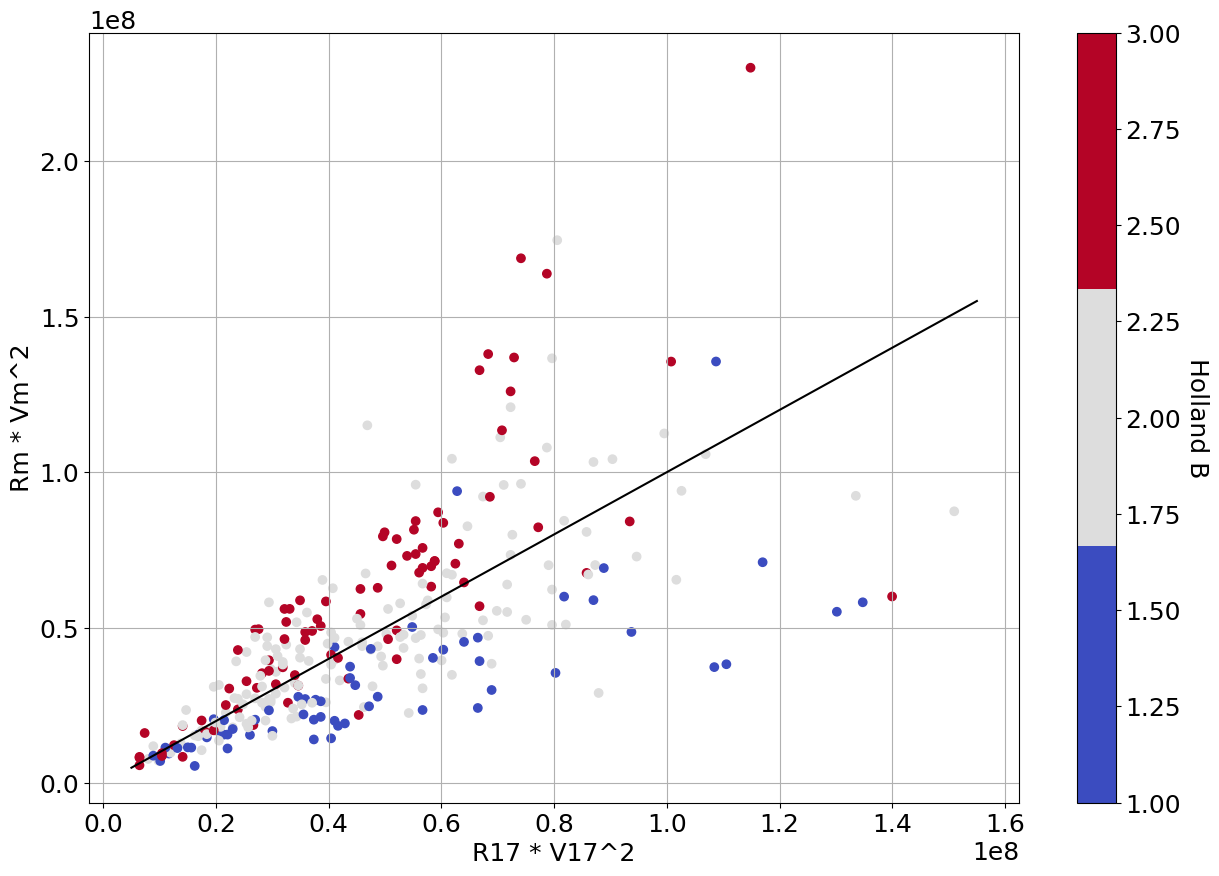

In [14]:
# plt.scatter(dsg['R17_1D'] * 1000 * 17.5 ** 2, dsg['Rmax_1D'] * 1000 * dsg['Vmax_1D'] ** 2, c=dsg.Vmax_dot_smth_IBT, vmin=-1, vmax=1, cmap=cm.get_cmap('coolwarm', 3))
plt.scatter(dsg['R17_1D'] * 1000 * 17.5 ** 2, dsg['Rmax_1D'] * 1000 * dsg['Vmax_1D'] ** 2, c=dsg.B_hol, vmin=1, vmax=3, cmap=cm.get_cmap('coolwarm', 3))
plt.grid()
plt.xlabel('R17 * V17^2');plt.ylabel('Rm * Vm^2')

cbar    = plt.colorbar()
cbar.set_label('Holland B', rotation=270)
cbar.ax.get_yaxis().labelpad=20

plt.plot([0.05e8, 1.55e8], [0.05e8, 1.55e8], c='k')

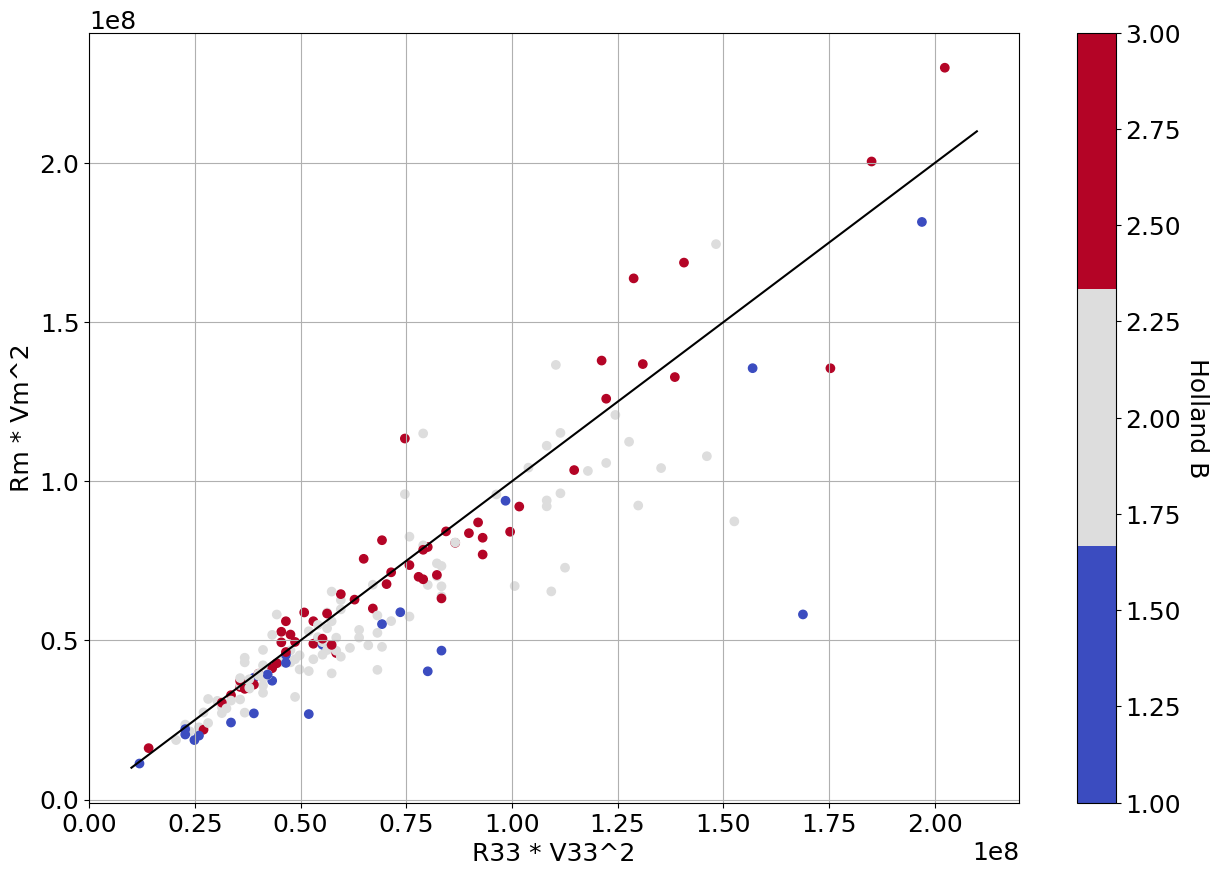

In [15]:
# d = dsg.where(abs(dsg.Vmax_dot_smth_IBT) > 0.3, drop=True)
# d = dsg.where(dsg.Vmax_1D > 33, drop=True)
# d = d.where(d.Rmax_1D < 100, drop=True)
# d = d.where(abs(d.lat_center) < 30, drop=True)
d = dsg.copy(deep=True)

plt.scatter(d['R33_1D'] * 1000 * 32.9 ** 2, d['Rmax_1D'] * 1000 * d['Vmax_1D'] ** 2, c=d.B_hol, vmin=1, vmax=3, cmap=cm.get_cmap('coolwarm', 3))
plt.grid()
plt.xlabel('R33 * V33^2');plt.ylabel('Rm * Vm^2')

cbar    = plt.colorbar()
cbar.set_label('Holland B', rotation=270)
cbar.ax.get_yaxis().labelpad=20

plt.plot([0.1e8, 2.1e8], [0.1e8, 2.1e8], c='k')

In [16]:
dsg['tau'] = 100 * 17.5 * dsg['R17_1D'] * 1000 / (dsg['Rmax_1D'] * 1000 * dsg['Vmax_1D'] ** 2) # hours
# dsg['tau'] = 100 * 17.5 * dsg['R17_1D'] * 1000 / (dsg['Rmax_1D'] * 1000 * dsg['Vmax_1D'] ** 2) # hours

In [17]:
# plt.scatter(dsg['hrs_since_lmi'], dsg['tau'], c=dsg.B_hol, vmin=1, vmax=3, cmap=cm.get_cmap('coolwarm', 3))

In [18]:
# dsg['tau2'] = (dsg['Rmax_1D'] * 1000 / dsg['Vmax_1D']) / 3600 # hours
# plt.scatter(dsg['hrs_since_lmi'], dsg['tau'] / dsg['tau2'], c=dsg.B_hol, vmin=1, vmax=3, cmap=cm.get_cmap('coolwarm', 3))

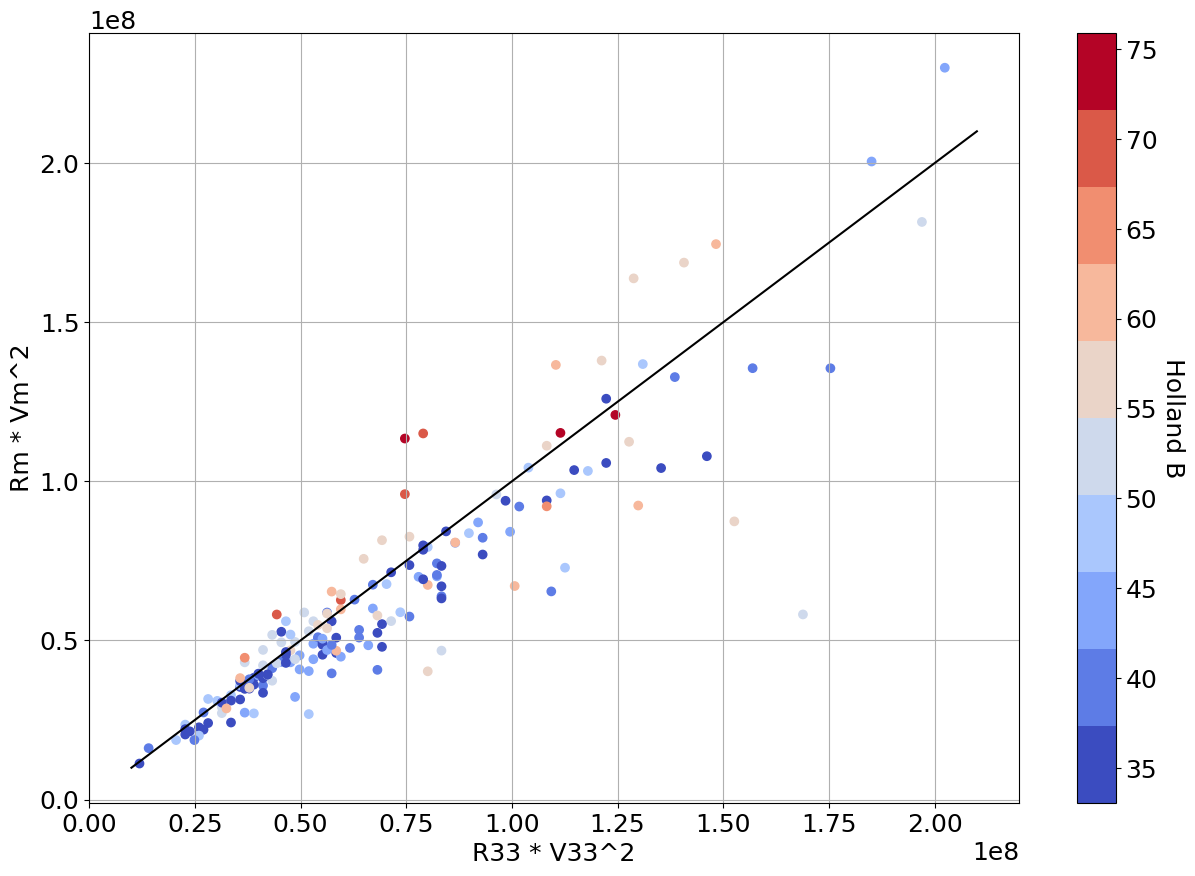

In [19]:
# d = dsg.where(abs(dsg.Vmax_dot_smth_IBT) > 0.3, drop=True)
# d = dsg.where(dsg.Vmax_1D > 33, drop=True)
# d = d.where(d.Rmax_1D < 100, drop=True)
# d = d.where(abs(d.lat_center) < 30, drop=True)
d = dsg.copy(deep=True)

plt.scatter(d['R33_1D'] * 1000 * 32.9 ** 2, d['Rmax_1D'] * 1000 * d['Vmax_1D'] ** 2, c=d.Vmax_1D, cmap=cm.get_cmap('coolwarm', 10))
plt.grid()
plt.xlabel('R33 * V33^2');plt.ylabel('Rm * Vm^2')

cbar    = plt.colorbar()
cbar.set_label('Holland B', rotation=270)
cbar.ax.get_yaxis().labelpad=20

plt.plot([0.1e8, 2.1e8], [0.1e8, 2.1e8], c='k')

#### Isolating cases

In [20]:
d.where((d['R33_1D'] * 1000 * 32.9 ** 2 < 0.75e8) & (d['Rmax_1D'] * 1000 * d['Vmax_1D'] ** 2 > 0.7e8), drop=True).sat_file

<xarray.DataArray 'sat_file' (time: 5)>
array([array('s1a-ew-owi-cm-20201003t022600-20201003t022817-000003-04082E_sw.nc',
             dtype=object)                                                       ,
       array('s1a-iw-owi-cm-20200827t000908-20200827t001138-000003-03F518_sw.nc',
             dtype=object)                                                       ,
       array('rs2--owi-cm-20140717t225349-20140717t225504-00003-BDBE0_sw.nc',
             dtype=object)                                                   ,
       array('rs2--owi-cm-20160712t022824-20160712t022940-00003-2B711_sw.nc',
             dtype=object)                                                   ,
       array('s1a-ew-owi-cm-20181009t234305-20181009t234610-000003-02A153_sw.nc',
             dtype=object)                                                       ],
      dtype=object)
Coordinates:
  * time     (time) datetime64[ns] 2020-10-03T02:27:08 ... 2018-10-09T23:44:37

In [21]:
d.where((d['R33_1D'] * 1000 * 32.9 ** 2 < 1.5e8) & (d['Rmax_1D'] * 1000 * d['Vmax_1D'] ** 2 > 1.5e8), drop=True).sat_file

<xarray.DataArray 'sat_file' (time: 3)>
array([array('rs2--owi-cm-20210419t212838-20210419t212954-00003-F7A22_sw.nc',
             dtype=object)                                                   ,
       array('s1b-iw-owi-cm-20210420t094117-20210420t094300-000003-032B99_sw.nc',
             dtype=object)                                                       ,
       array('s1a-ew-owi-cm-20181025t203134-20181025t203308-000003-02A8D5_sw.nc',
             dtype=object)                                                       ],
      dtype=object)
Coordinates:
  * time     (time) datetime64[ns] 2021-04-19T21:29:16 ... 2018-10-25T20:32:21

#### Tests

In [ ]:
# plt.hist(dsg['cyclone_speed'], bins=100)
# plt.grid()
# plt.xlim(0, 10)

In [62]:
d_low = dsg.where(dsg.cyclone_speed < 3, drop=True)
d_med = dsg.where((dsg.cyclone_speed >= 3) & (dsg.cyclone_speed < 6), drop=True)
d_hgh = dsg.where(dsg.cyclone_speed >= 6, drop=True)
print('#Slow   storms = {}'.format(len(d_low.time)))
print('#Normal storms = {}'.format(len(d_med.time)))
print('#Quick  storms = {}'.format(len(d_hgh.time)))

#Slow   storms = 72
#Normal storms = 158
#Quick  storms = 105


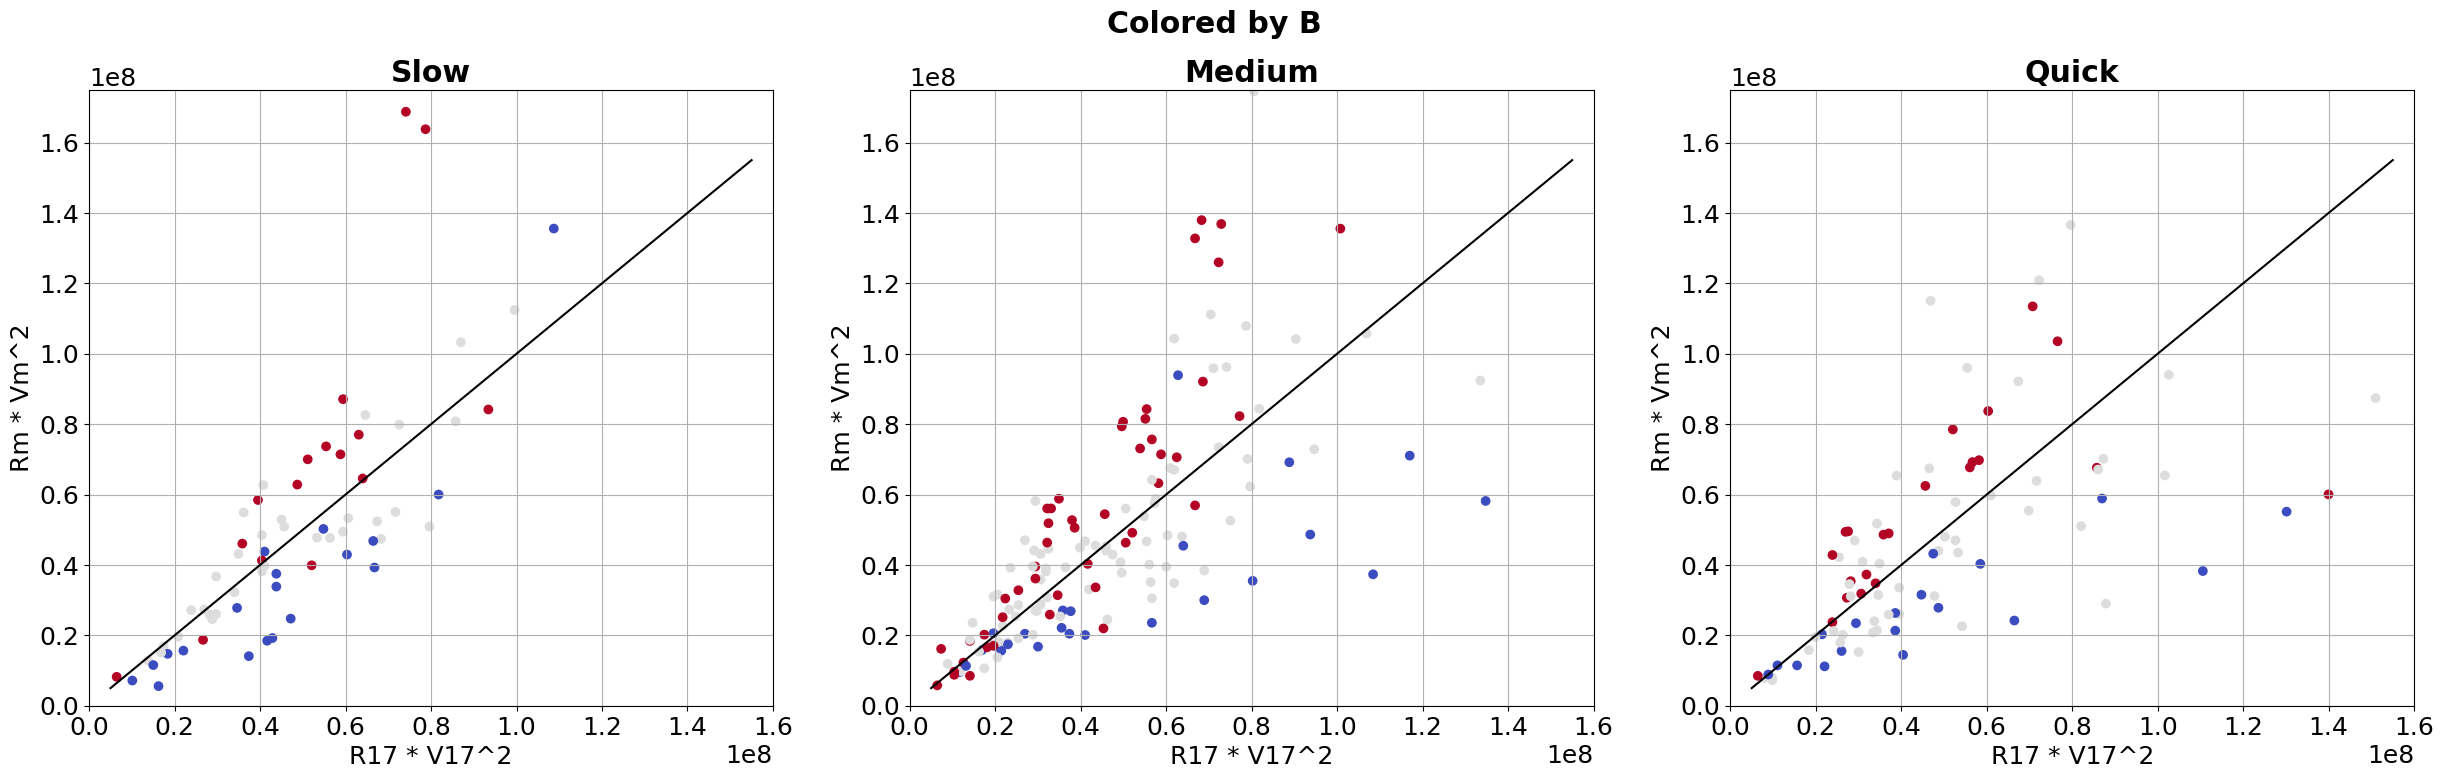

In [63]:
fig, axs = plt.subplots(figsize=(30, 8), nrows=1, ncols=3)
plt.suptitle('Colored by B', weight='bold')

for ax, d, ttl in zip(axs, [d_low, d_med, d_hgh], ['Slow', 'Medium', 'Quick']):
    ax.set_title('{}'.format(ttl), weight='bold')
    ax.scatter(d['R17_1D'] * 1000 * 17.5 ** 2, d['Rmax_1D'] * 1000 * d['Vmax_1D'] ** 2, c=d.B_hol, vmin=1, vmax=3, cmap=cm.get_cmap('coolwarm', 3))
    ax.grid()
    ax.set_xlabel('R17 * V17^2');ax.set_ylabel('Rm * Vm^2')
    ax.plot([0.05e8, 1.55e8], [0.05e8, 1.55e8], c='k')
    ax.set_xlim(0, 1.6e8)
    ax.set_ylim(0, 1.75e8)

In [64]:
d_low = dsg.where(dsg.B_hol < 1.6, drop=True)
d_med = dsg.where((dsg.B_hol >= 1.6) & (dsg.B_hol < 2.3), drop=True)
d_hgh = dsg.where(dsg.B_hol >= 2.3, drop=True)
print('#Low B    storms = {}'.format(len(d_low.time)))
print('#Medium B storms = {}'.format(len(d_med.time)))
print('#High B   storms = {}'.format(len(d_hgh.time)))

#Low B    storms = 69
#Medium B storms = 168
#High B   storms = 98


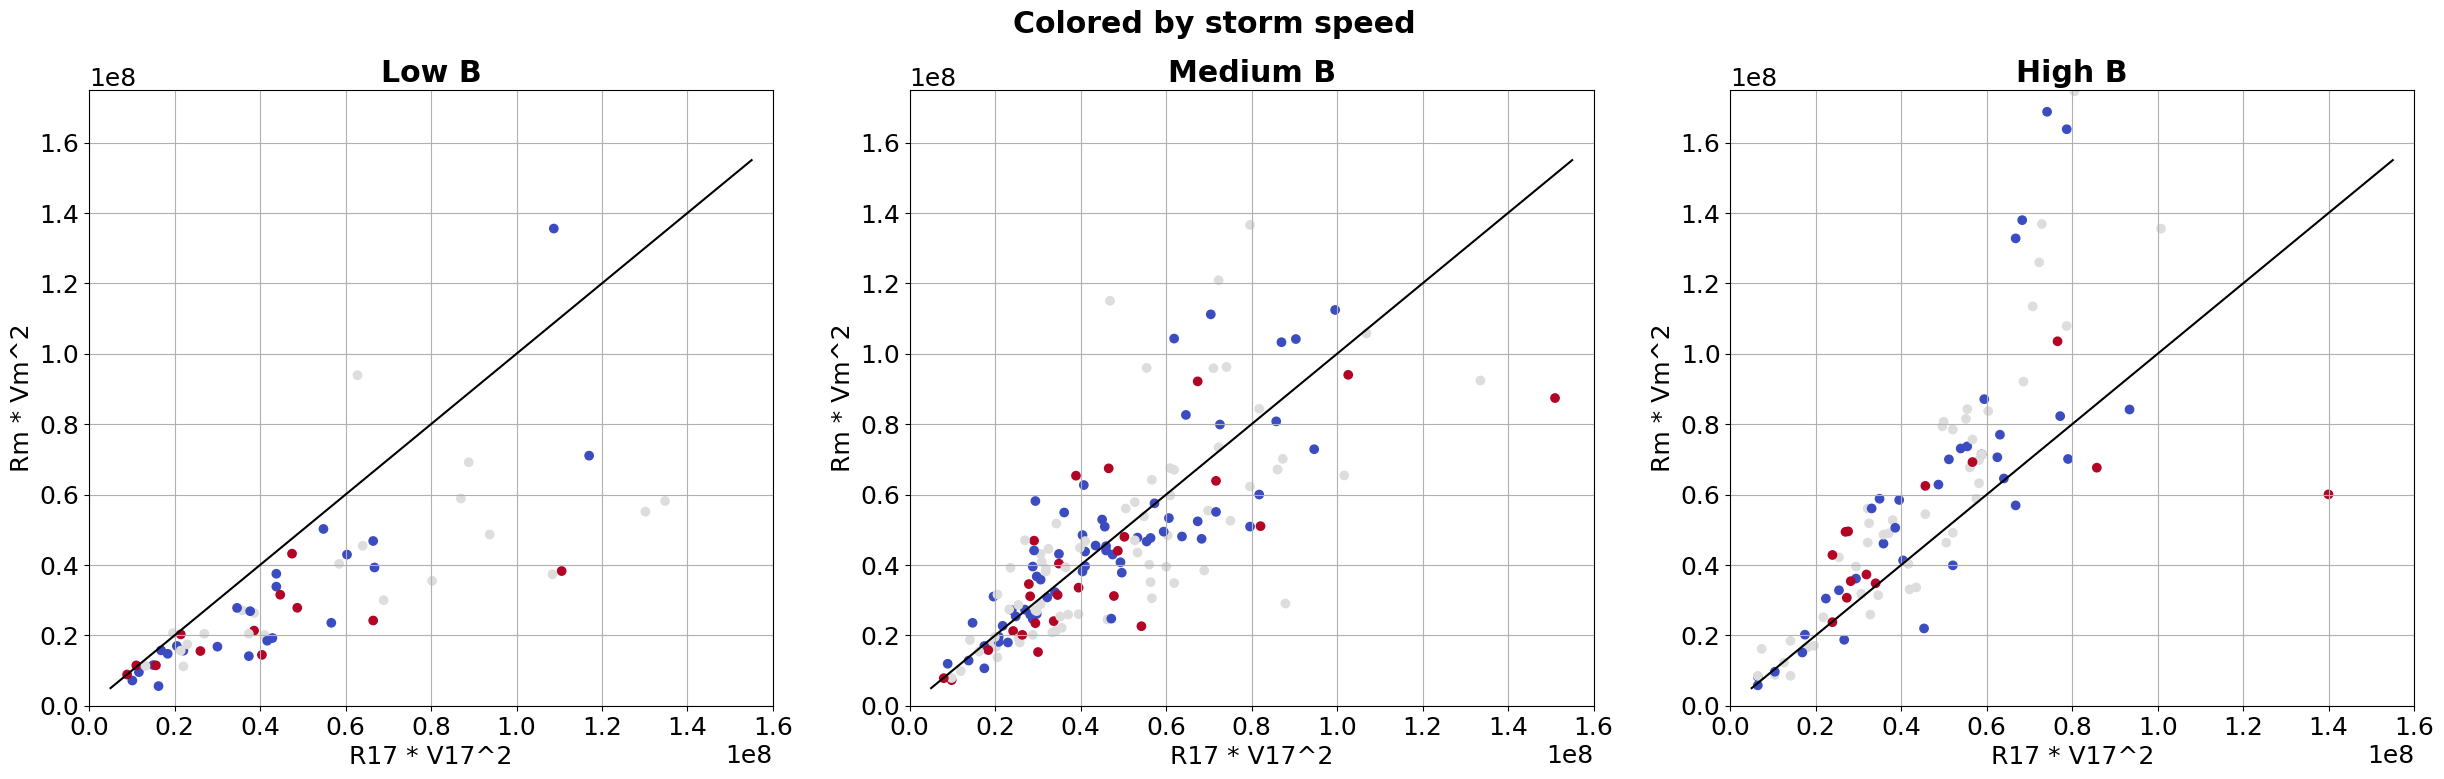

In [65]:
fig, axs = plt.subplots(figsize=(30, 8), nrows=1, ncols=3)
plt.suptitle('Colored by storm speed', weight='bold')

for ax, d, ttl in zip(axs, [d_low, d_med, d_hgh], ['Low B', 'Medium B', 'High B']):
    ax.set_title('{}'.format(ttl), weight='bold')
    ax.scatter(d['R17_1D'] * 1000 * 17.5 ** 2, d['Rmax_1D'] * 1000 * d['Vmax_1D'] ** 2, c=d.cyclone_speed, vmin=1, vmax=10, cmap=cm.get_cmap('coolwarm', 3))
    ax.grid()
    ax.set_xlabel('R17 * V17^2');ax.set_ylabel('Rm * Vm^2')
    ax.plot([0.05e8, 1.55e8], [0.05e8, 1.55e8], c='k')
    ax.set_xlim(0, 1.6e8)
    ax.set_ylim(0, 1.75e8)

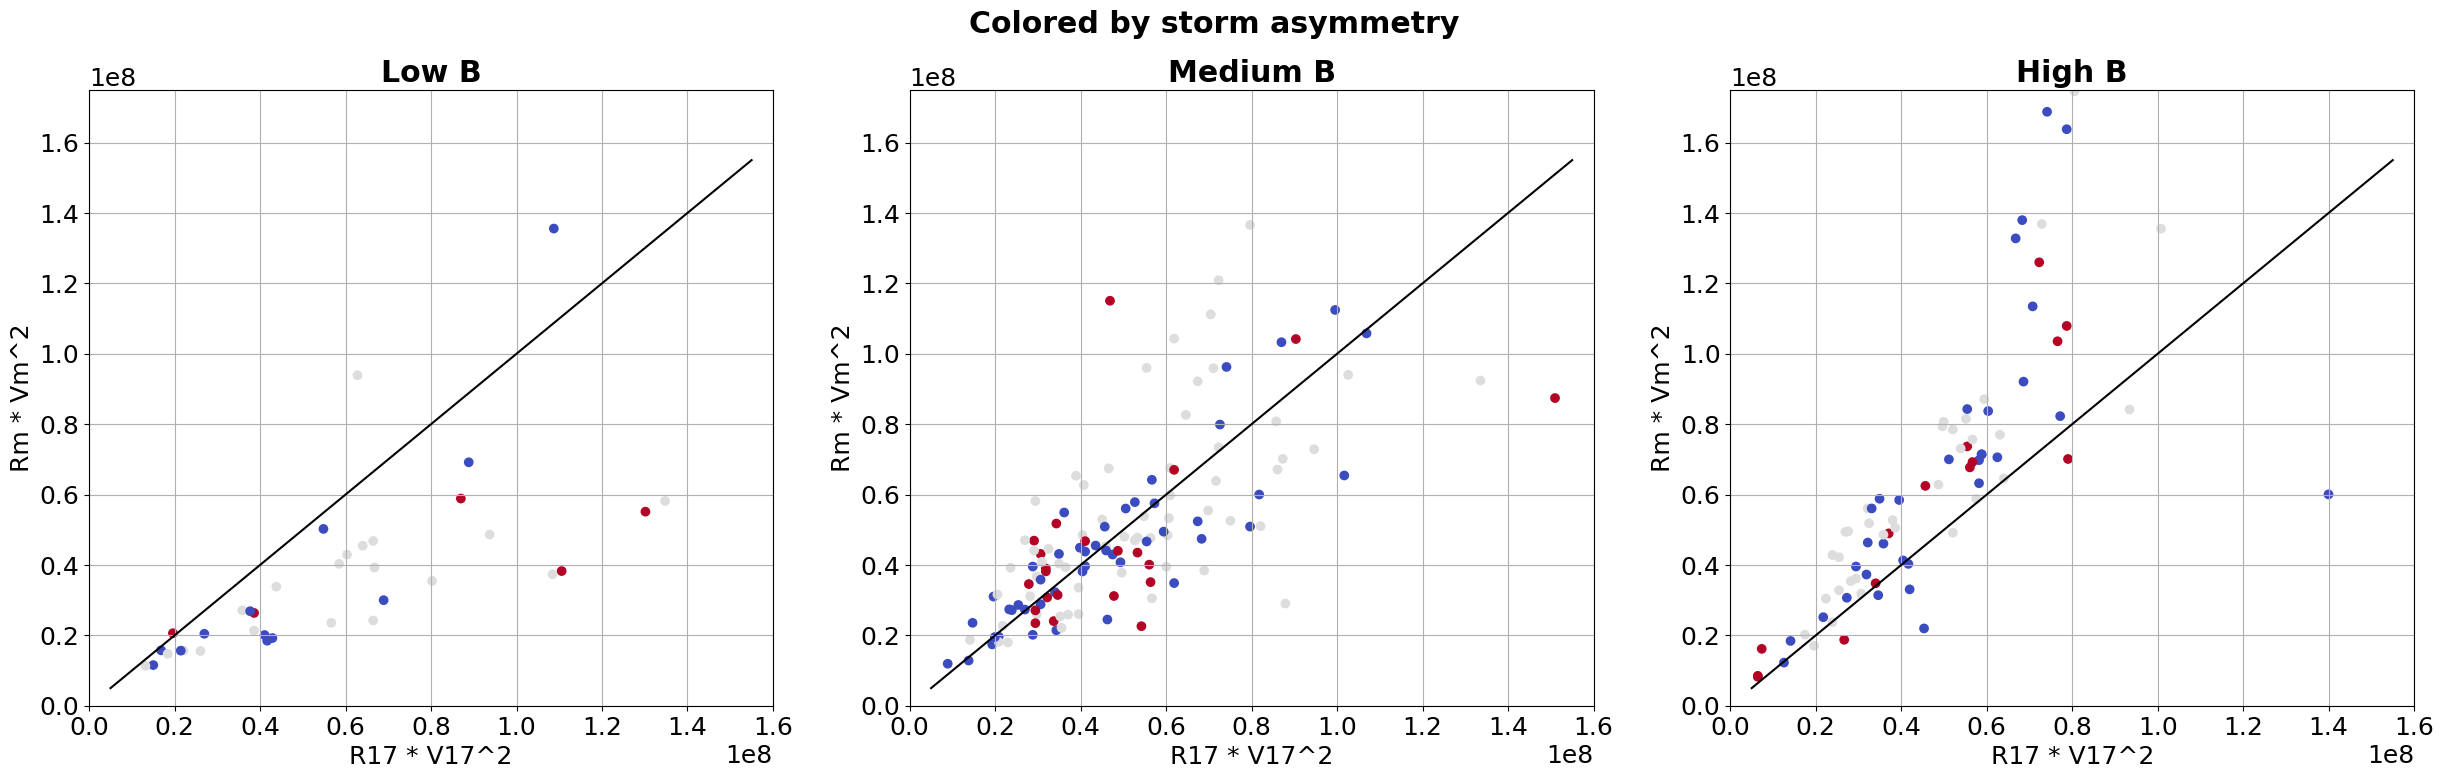

In [71]:
fig, axs = plt.subplots(figsize=(30, 8), nrows=1, ncols=3)
plt.suptitle('Colored by storm asymmetry', weight='bold')

for ax, d, ttl in zip(axs, [d_low, d_med, d_hgh], ['Low B', 'Medium B', 'High B']):
    ax.set_title('{}'.format(ttl), weight='bold')
    ax.scatter(d['R17_1D'] * 1000 * 17.5 ** 2, d['Rmax_1D'] * 1000 * d['Vmax_1D'] ** 2, c=d.V26_STD, vmin=1, vmax=7, cmap=cm.get_cmap('coolwarm', 3))
    ax.grid()
    ax.set_xlabel('R17 * V17^2');ax.set_ylabel('Rm * Vm^2')
    ax.plot([0.05e8, 1.55e8], [0.05e8, 1.55e8], c='k')
    ax.set_xlim(0, 1.6e8)
    ax.set_ylim(0, 1.75e8)

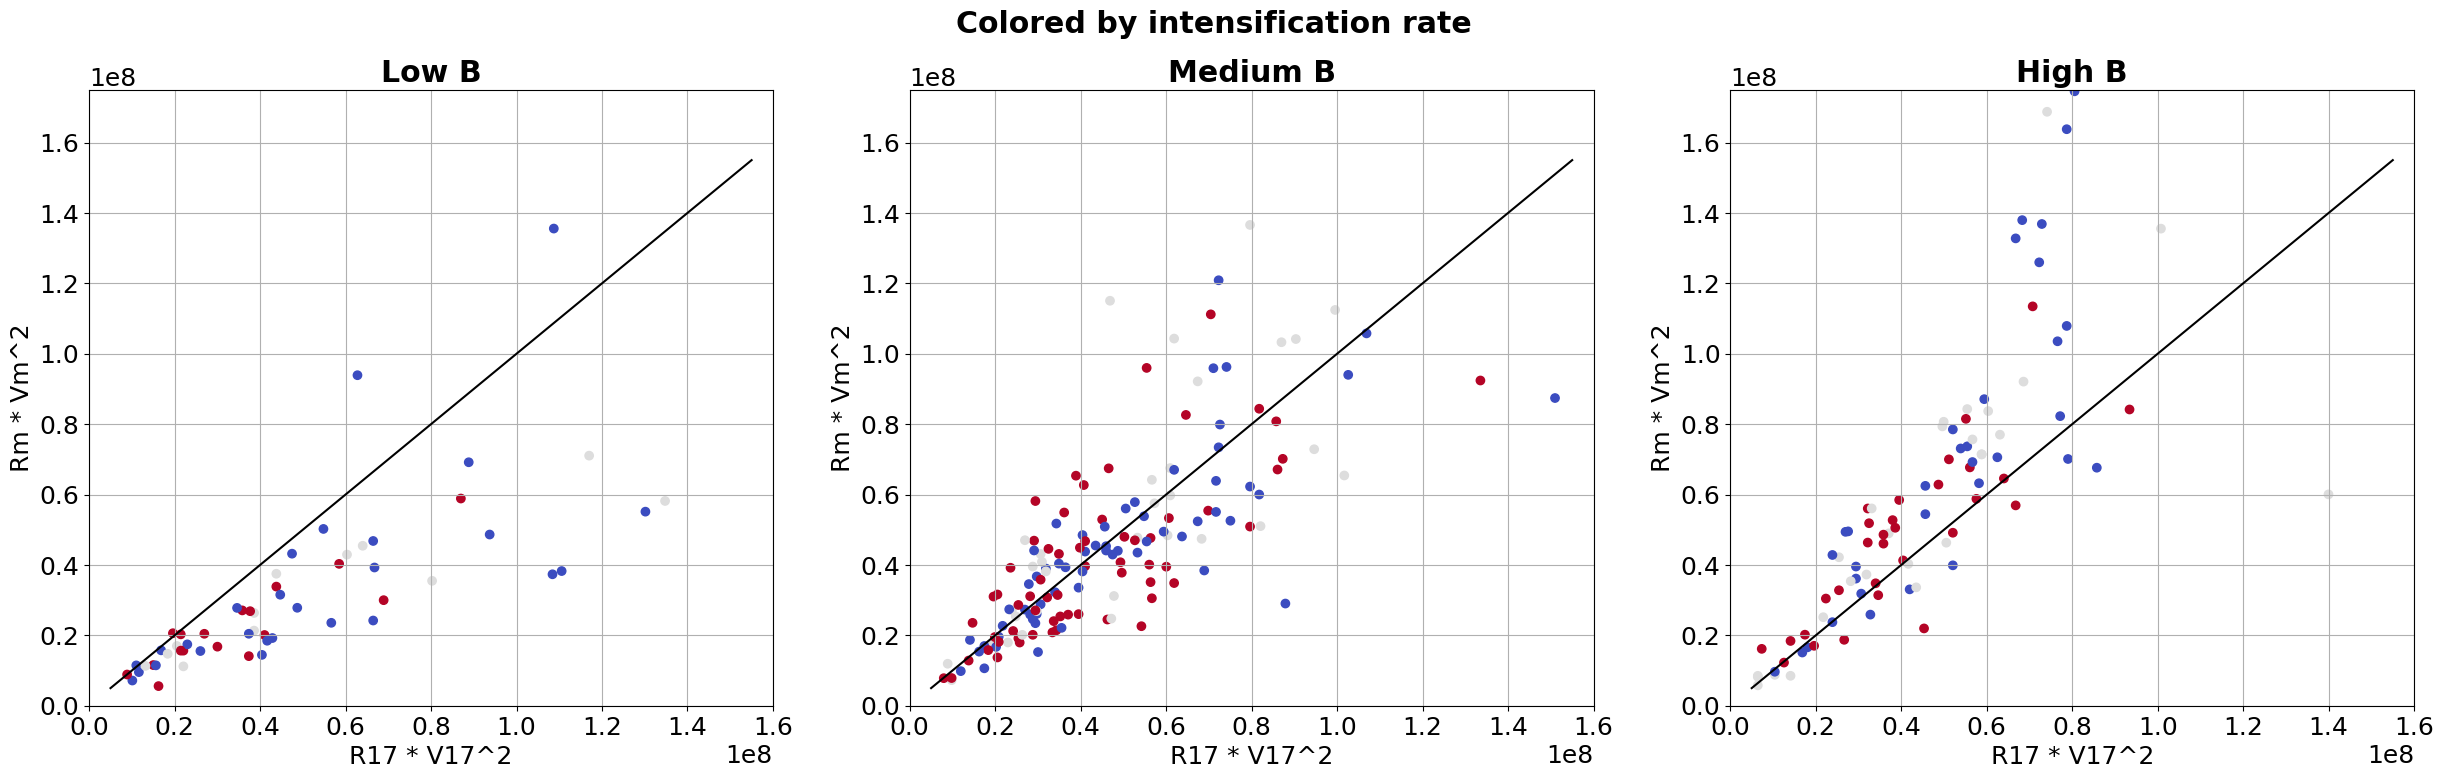

In [75]:
fig, axs = plt.subplots(figsize=(30, 8), nrows=1, ncols=3)
plt.suptitle('Colored by intensification rate', weight='bold')

for ax, d, ttl in zip(axs, [d_low, d_med, d_hgh], ['Low B', 'Medium B', 'High B']):
    ax.set_title('{}'.format(ttl), weight='bold')
    ax.scatter(d['R17_1D'] * 1000 * 17.5 ** 2, d['Rmax_1D'] * 1000 * d['Vmax_1D'] ** 2, c=d.Vmax_dot_smth_IBT, vmin=-0.6, vmax=0.6, cmap=cm.get_cmap('coolwarm', 3))
    ax.grid()
    ax.set_xlabel('R17 * V17^2');ax.set_ylabel('Rm * Vm^2')
    ax.plot([0.05e8, 1.55e8], [0.05e8, 1.55e8], c='k')
    ax.set_xlim(0, 1.6e8)
    ax.set_ylim(0, 1.75e8)